In [1]:
import torch
import torchvision
from torchvision import transforms as T
import os
from PIL import Image
import pandas as pd
import numpy as np
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import torch_snippets as ts
from torch_snippets import Report
import cv2
import math

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Faster CNN

In [3]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_object_detection_model(num_classes = 2, 
                               feature_extraction = True, device="cpu"):
    """
    Inputs
        num_classes: int
            Number of classes to predict. Must include the 
            background which is class 0 by definition!
        feature_extraction: bool
            Flag indicating whether to freeze the pre-trained 
            weights. If set to True the pre-trained weights will be  
            frozen and not be updated during.
    Returns
        model: FasterRCNN
    """
    # Load the pretrained faster r-cnn model.
    model = fasterrcnn_resnet50_fpn(weights = None)
    # If True, the pre-trained weights will be frozen.
    if feature_extraction == True:
        for p in model.parameters():
            p.requires_grad = False
    # Replace the original 91 class top layer with a new layer
    # tailored for num_classes.
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats,
                                                   num_classes)
 
    return model

In [4]:
class Compose:
    """
    Composes several torchvision image transforms 
    as a sequence of transformations.
    Inputs
        transforms: list
            List of torchvision image transformations.
    Returns
        image: tensor
        target: dict
    """
    def __init__(self, transforms = []):
        self.transforms = transforms
    # __call__ sequentially performs the image transformations on
    # the input image, and returns the augmented image.
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor(torch.nn.Module):
    """
    Converts a PIL image into a torch tensor.
    Inputs
        image: PIL Image
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        image = F.pil_to_tensor(image)
        image = F.convert_image_dtype(image)
        return image, target

def get_transform(train):
    """
    Transforms a PIL Image into a torch tensor, and performs
    random horizontal flipping of the image if training a model.
    Inputs
        train: bool
            Flag indicating whether model training will occur.
    Returns
        compose: Compose
            Composition of image transforms.
    """
    transforms = []
    # ToTensor is applied to all images.
    transforms.append(ToTensor())
    # The following transforms are applied only to the train set.
    # if train == True:
        # transforms.append(RandomHorizontalFlip(0.5))
        # Other transforms can be added here later on.
    return Compose(transforms)

### Helper functions to train the model

In [5]:
def unbatch(batch, device):
    """
    Unbatches a batch of data from the Dataloader.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        X: list
            List of images.
        y: list
            List of dictionaries containing the bounding box
    """
    
    X, y = batch
  
    X = [x.to(device) for x in X]

    y = [{k: v.to(device) for k, v in t.items()} for t in y]
 

    return X, y
def train_batch(batch, model, optimizer, device):
    """
    Uses back propagation to train a model.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses
@torch.no_grad()
def validate_batch(batch, model, optimizer, device):
    """
    Evaluates a model's loss value using validation data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    return loss, losses



### Driver Code

In [6]:
# temp_model_state_path = "localization\temp"
def train_fasterrcnn(model, 
                 optimizer, 
                  n_epochs, 
              train_loader, 
        test_loader = None, 
                log = None, 
               keys = None, 
            device = "cpu"):
    """
    Trains a FasterRCNN model using train and validation 
    Dataloaders over n_epochs. 
    Returns a Report on the training and validation losses.
    Inputs
        model: FasterRCNN
        optimizer: torch optimizer
        n_epochs: int
            Number of epochs to train.
        train_loader: DataLoader
        test_loader: DataLoader
        log: Record
            torch_snippet Record to record training progress.
        keys: list
            List of strs containing the FasterRCNN loss names.
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        log: Record
            torch_snippet Record containing the training records.
    """
    # load the model if it exists
    # if os.path.exists(temp_model_state_path):
    #     model.load_state_dict(torch.load(temp_model_state_path))
        
    if log is None:
        log = Report(n_epochs)
    if keys is None:
        # FasterRCNN loss names.
        keys = ["loss_classifier", 
                   "loss_box_reg", 
                "loss_objectness", 
               "loss_rpn_box_reg"]
    model.to(device)
    for epoch in range(n_epochs):
        N = len(train_loader)
        for ix, batch in enumerate(train_loader):
            loss, losses = train_batch(batch, model, 
                                  optimizer, device)
            # Record the current train loss.
            pos = epoch + (ix + 1) / N
            log.record(pos = pos, trn_loss = loss.item(), 
                       end = "\r")
        if test_loader is not None:
            N = len(test_loader)
            for ix, batch in enumerate(test_loader):
                loss, losses = validate_batch(batch, model, 
                                         optimizer, device)
                
                # Record the current validation loss.
                pos = epoch + (ix + 1) / N
                log.record(pos = pos, val_loss = loss.item(), 
                           end = "\r")
    # save at the end of each epoch
    # torch.save(model.state_dict(), temp_model_state_path)
    log.report_avgs(epoch + 1)
    return log

### Dataset

In [7]:
# apply transfer learning on faster cnn to train on our dataset to detect position of optical disk in fundus images

bounding_box_size = 50

class FundusDataset(torch.utils.data.Dataset):
    def __init__(self, images_root, annotations=None, transforms=None):
    
        self.transforms = transforms
        self.images_root = images_root
        self.annotations = annotations

        
        self.imgs = list(sorted(os.listdir(images_root)))
        # load csv file of locations of optical disk
        if annotations is not None:
            self.annotations = pd.read_csv(annotations)
            print(self.annotations.head())
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.images_root, self.imgs[idx])).convert("RGB")
        ann = None
        coordinates = [0,0]
        target = {}

        if self.annotations is not None:
            ann = self.annotations[self.annotations["Image No"] == self.imgs[idx].split(".")[0]]
            coordinates = ann[["X", "Y"]].values[0]
            bounding_box = torch.as_tensor([coordinates[0]-bounding_box_size, coordinates[1]-bounding_box_size, coordinates[0]+bounding_box_size, coordinates[1]+bounding_box_size], dtype=torch.float32)
            target["boxes"] = bounding_box.unsqueeze(0)
            target["labels"] = torch.as_tensor([1], dtype=torch.int64)
            target["image_id"] = torch.tensor([idx])

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        

        return img, target
    def __len__(self):
        return len(self.imgs)

### Training the Faster R-CNN Model

In [8]:
# Train and Validation Split
train_images = "C:\\Users\\hsr30\\Documents\\minor-project\\datasets\\idrid\\C. Localization\\1. Original Images\\a. Training Set"
train_annotaitons = "C:\\Users\\hsr30\\Documents\\minor-project\\datasets\\idrid\\C. Localization\\2. Groundtruths\\1. Optic Disc Center Location\\a. IDRiD_OD_Center_Training Set_Markups.csv"
valid_images = "C:\\Users\\hsr30\\Documents\\minor-project\\datasets\\idrid\\C. Localization\\1. Original Images\\b. Testing Set"
valid_annotaitons = "C:\\Users\\hsr30\\Documents\\minor-project\\datasets\\idrid\\C. Localization\\2. Groundtruths\\1. Optic Disc Center Location\\b. IDRiD_OD_Center_Testing Set_Markups.csv"


train_ds = FundusDataset(images_root=train_images, annotations= train_annotaitons , transforms=get_transform(train=True))
valid_ds = FundusDataset(images_root=valid_images, annotations= valid_annotaitons , transforms=get_transform(train=False))

# Collate image-target pairs into a tuple.
def collate_fn(batch):

    return tuple(zip(*batch))
# Create the DataLoaders from the Datasets. 
train_dl = torch.utils.data.DataLoader(train_ds, 
                                 batch_size = 10, 
                                 shuffle = True, 
                        drop_last=True, collate_fn=collate_fn)
val_dl = torch.utils.data.DataLoader(valid_ds, 
                             batch_size = 10, 
                            shuffle = False, collate_fn=collate_fn)

# print summary of train loader
print(f"Number of training batches: {len(train_dl)}")
# list of images and targets



    Image No     X     Y
0  IDRiD_001  2858  1805
1  IDRiD_002   943  1119
2  IDRiD_003   779  1269
3  IDRiD_004  1292  1284
4  IDRiD_005  1037  1198
    Image No     X     Y
0  IDRiD_001   651  1453
1  IDRiD_002  3158  1280
2  IDRiD_003  1101  1374
3  IDRiD_004  2881  1430
4  IDRiD_005  2840  1175
Number of training batches: 41


In [8]:
# Create the faster rcnn model with 3 classes - optical disk and 
# background.
model = get_object_detection_model(num_classes = 2,   
                        feature_extraction = False)
# Use the stochastic gradient descent optimizer.
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, 
                        lr = 0.01, 
                    momentum = 0.9, 
             weight_decay = 0.0005)
# Train the model over 1 epoch.

def train():
   log = train_fasterrcnn(model = model, 
                  optimizer = optimizer, 
                           n_epochs = 10,
               train_loader = train_dl, 
                  test_loader = val_dl,
               log = None, keys = None,
                        device = device)
   path = "C:\\Users\\hsr30\\Documents\\minor-project\\localization\\model"
   # get number of files in the directory
   num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
   new_model_name = "model" + str(num_files+1) + ".pth"
   torch.save(model.state_dict(), os.path.join(path, new_model_name))

### Load Model

In [9]:
# Load Model from file
model = get_object_detection_model(num_classes = 2,   
                        feature_extraction = False)
path = "C:\\Users\\hsr30\\Documents\\minor-project\\localization\\model"
model_name = "model-10e.pth"
model.load_state_dict(torch.load(os.path.join(path, os.path.basename(model_name))))

<All keys matched successfully>

### Model Predictions

In [10]:
@torch.no_grad()
def predict_batch(batch, model, device):
    """
    Gets the predictions for a batch of data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        images: list
            List of tensors of the images.
        predictions: list
            List of dicts containing the predictions for the 
            bounding boxes, labels and confidence scores.
    """
    model.to(device)
    model.eval()
    X, _ = unbatch(batch, device = device)
    predictions = model(X)
    return [x.cpu() for x in X], predictions
def predict(model, data_loader, device = "cpu"):
    """
    Gets the predictions for a batch of data.
    Inputs
        model: torch model
        data_loader: torch Dataloader
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        images: list
            List of tensors of the images.
        predictions: list
            List of dicts containing the predictions for the 
            bounding boxes, labels and confidence scores.
    """
    images = []
    predictions = []
    current_percentage = 0
    for i, batch in enumerate(data_loader):
        X, p = predict_batch(batch, model, device)
        images = images + X
        predictions = predictions + p
        # print progress

        percentage = math.floor((i/len(data_loader))*100)
        if percentage > current_percentage:
            current_percentage = percentage
            print(f"Predicting: {current_percentage}% done", end="\r")
    
    return images, predictions

def predict_single(model, image, device = "cpu"):
    """
    Gets the predictions for a single image.
    Inputs
        model: torch model
        image: PIL Image
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        image: tensor
        prediction: dict
            Dict containing the predictions for the bounding 
            boxes, labels and confidence scores.
    """
    model.to(device)
    model.eval()
    image = F.pil_to_tensor(image)
    image = F.convert_image_dtype(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    prediction = model(image)
    return image, prediction

# Plot the image and the predicted bounding box.
def plot_prediction(image, prediction, threshold = 0.5):
    """
    Plots the image and the predicted bounding box.
    Inputs
        image: tensor
        prediction: dict
            Dict containing the predictions for the bounding 
            boxes, labels and confidence scores.
        threshold: float
            Confidence score threshold.
    """
    boxes = prediction[0]["boxes"].cpu().detach().numpy()
    scores = prediction[0]["scores"].cpu().detach().numpy()
    # Get boxes above the confidence threshold.
    boxes = boxes[scores >= threshold].astype(np.int32)
    # Plot the image with the predicted bounding boxes.
    fig, ax = plt.subplots(1, 1, figsize = (16, 8))
    image = image.cpu().detach().numpy().transpose(1, 2, 0)
    for box in boxes:
        cv2.rectangle(image, (box[0], box[1]), 
                      (box[2], box[3]), (0, 255, 0), 10)
    ax.set_axis_off()
    ax.imshow(image)
    plt.show()

### Predicting images from the test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


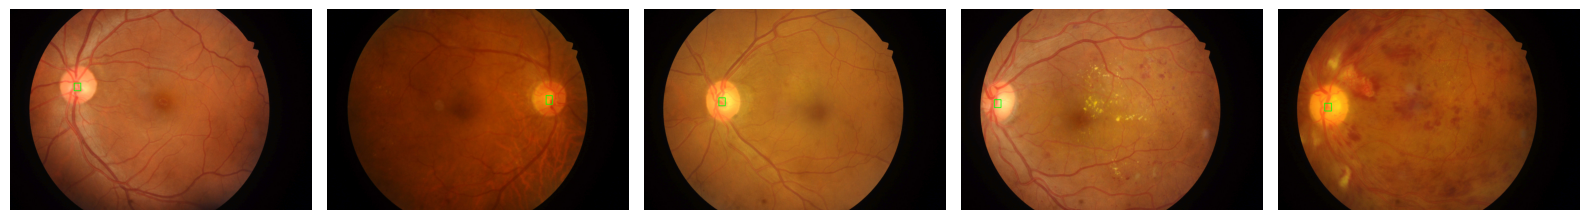

In [11]:
# randomly choose 10 images from the test set and plot the predictions
# get 10 random images from the test set
test_images_folder = "C:\\Users\\hsr30\\Documents\\minor-project\\datasets\\idrid\\C. Localization\\1. Original Images\\b. Testing Set"
test_images = os.listdir(test_images_folder)
number_of_test_images = 5
test_images = np.random.choice(test_images, number_of_test_images)
threshold = 0.6
# get the predictions for the 10 images
images = []
predictions = []
for image_name in test_images:
    image_path = os.path.join(test_images_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    image, prediction = predict_single(model, image, device = device)
    images.append(image[0])
    predictions.append(prediction)
# plot the predictions
fig, axes = plt.subplots(math.ceil(number_of_test_images/5), 5, figsize = (16, 8))
axes = axes.flatten()
for image, prediction, ax in zip(images, predictions, axes):
    boxes = prediction[0]["boxes"].cpu().detach().numpy()
    scores = prediction[0]["scores"].cpu().detach().numpy()
    # Get boxes above the confidence threshold.
    boxes = boxes[scores >= threshold].astype(np.int32)
    # highest scoring box
    box = boxes[np.argmax(scores)]
    # Plot the image with the predicted bounding boxes.
    image = image.cpu().detach().numpy().transpose(1, 2, 0)

    cv2.rectangle(image, (box[0], box[1]), 
                      (box[2], box[3]), (0, 200, 0), 10)
    ax.imshow(image)

    ax.set_axis_off()
plt.tight_layout()
plt.show()


In [15]:
# # Predict a large dataset and save the predictions in a csv file
# # Note: perform predictions on the using batches of images
# # to avoid memory issues.
images_folder = "C:\\Users\\hsr30\\Documents\\minor-project\\datasets\\idrid\\B. Disease Grading\\1. Original Images\\b. Testing Set"
images = os.listdir(images_folder)
batch_size = 8
total_images = len(images)
print(f"Total number of images: {total_images}")
# get the predictions for all the images using batches of 10 images
predictions = []
percentage = 0

for i in range(0, total_images, batch_size):
    batch_images = []
    for image_name in images[i:i+batch_size]:
        image_path = os.path.join(images_folder, image_name)
        image = Image.open(image_path).convert("RGB")
        image = F.pil_to_tensor(image)
        image = F.convert_image_dtype(image)
        batch_images.append(image)
    batch_images = torch.stack(batch_images)
    batch_images = batch_images.to(device)
    prediction = model(batch_images)
    # convert the predictions to numpy arrays and choose the highest scoring box for each image
    for image_name, prediction in zip(images[i:i+batch_size], prediction):
        if len(prediction["boxes"]) == 0:
            continue
       
        boxes = prediction["boxes"].cpu().detach().numpy()
        scores = prediction["scores"].cpu().detach().numpy()
        # highest scoring box
        box = boxes[np.argmax(scores)]
        # save the predictions
        predictions.append([image_name, box[0], box[1], box[2], box[3]])
    # print progress
    percentage = math.floor((i/total_images)*100)
    print(f"Predicting: {percentage}% done", end="\r")
print("Predicting: 100% done")
print(predictions)

Total number of images: 103
Predicting: 100% done
[['IDRiD_002.jpg', 3111.58, 1226.7864, 3199.8628, 1349.9103], ['IDRiD_003.jpg', 1122.3236, 1439.6748, 1219.4232, 1546.025], ['IDRiD_004.jpg', 2849.0383, 1387.8528, 2942.168, 1500.4907], ['IDRiD_005.jpg', 2794.673, 1106.6444, 2891.7268, 1223.3096], ['IDRiD_006.jpg', 2910.6118, 1433.9668, 3011.9712, 1551.9297], ['IDRiD_007.jpg', 802.2712, 1324.4475, 899.4862, 1433.1294], ['IDRiD_008.jpg', 829.60516, 1256.7079, 921.9546, 1369.9967], ['IDRiD_009.jpg', 3189.857, 1545.9006, 3286.8486, 1653.1815], ['IDRiD_010.jpg', 2882.7642, 1593.1576, 2980.3665, 1707.3322], ['IDRiD_011.jpg', 827.21027, 1325.4108, 924.9347, 1431.0804], ['IDRiD_012.jpg', 600.25995, 1089.1495, 698.9831, 1195.4913], ['IDRiD_013.jpg', 808.14526, 1167.2186, 899.40106, 1279.0126], ['IDRiD_014.jpg', 730.34784, 1571.8484, 827.26746, 1685.0985], ['IDRiD_015.jpg', 3024.5068, 1411.259, 3117.5261, 1517.5073], ['IDRiD_016.jpg', 3190.32, 1275.6326, 3285.6052, 1387.645], ['IDRiD_017.jpg', 3

In [16]:
# save the predictions in a csv file
predictions = pd.DataFrame(predictions, columns=["Image No", "X", "Y", "Width", "Height"])
predictions.to_csv("C:\\Users\\hsr30\\Documents\\minor-project\\localization\\testing-boxes.csv", index=False)

In [ ]:
# test_images_folder = "C:\\Users\\hsr30\\Documents\\minor-project\\datasets\\idrid\\C. Localization\\1. Original Images\\a. Training Set"
# test_image_ds = FundusDataset(images_root=test_images_folder, annotations=None, transforms=get_transform(train=False))
# test_image_dl = torch.utils.data.DataLoader(test_image_ds, 
#                                  batch_size = 12, 
#                                  shuffle = True)
# print(f"Total number of test images: {len(test_image_dl)}")
# predictions = predict(model, test_image_dl, device = device)

Total number of test images: 35


: 